In [31]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import trange
import imageio  # optional: used to build GIF from snapshots
from PIL import Image




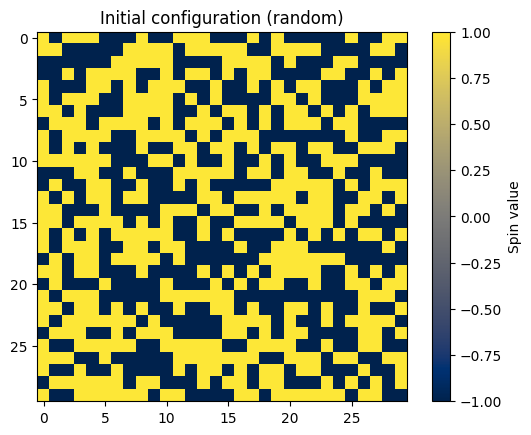

In [32]:
# Parameters for the run (tweak these)
L = 30                    # lattice linear size (must match your spins shape)
J = 1.0
kB = 1.0
T = 1.6                      # temperature after quench (T < Tc=2.2-ish to see coarsening)
beta = 1.0 / (kB * T)
rng = np.random.default_rng(24)   # reproducible seed

init_mode = "random"         # "random" or "ordered"
n_eq_sweeps = 0              # equilibration sweeps (set 0 if you want to watch full relaxation)
n_meas_sweeps = 500          # number of measurement sweeps (time steps you'll record)
sample_every = 5             # save a snapshot every this many sweeps
snapshot_dir = "glauber_snapshots"
gif_out = "glauber_evolution.gif"

os.makedirs(snapshot_dir, exist_ok=True)

# Initialize spins (re-using your convention)
if init_mode == "random":
    spins = rng.choice([-1, 1], size=(L, L)).astype(np.int8)
else:
    spins = np.ones((L, L), dtype=np.int8)

# --- Initialize spins ---
# Choose "random" or "ordered"
init_mode = "random"  # or "ordered"

if init_mode == "random":
    spins = rng.choice([-1, 1], size=(L, L)).astype(np.int8)
elif init_mode == "ordered":
    spins = np.ones((L, L), dtype=np.int8)
else:
    raise ValueError("init_mode must be 'random' or 'ordered'")

# --- Visualize ---
plt.imshow(spins, cmap='cividis')
plt.title(f"Initial configuration ({init_mode})")
plt.colorbar(label="Spin value")
plt.show()

In [33]:
# Energy utilities for 2D Ising (total energy and delta energy)
import numpy as np

def total_energy(spins, J=1.0):
    """
    Compute total energy of 2D Ising on square lattice with periodic BC.
    Uses sum over right and down neighbours to avoid double counting.
    spins: 2D numpy array with values in {-1, +1}
    Returns: float total energy
    """
    L = spins.shape[0]
    E = 0
    for i in range(L):
        for j in range(L):
            s = spins[i, j]
            E -= J * s * (spins[(i + 1) % L, j] + spins[i, (j + 1) % L])
    return float(E)

def delta_energy(spins, i, j, J=1.0):
    """
    Compute energy change ΔE when flipping spin at (i,j).
    ΔE = 2 * J * s_ij * sum_nn
    Returns integer ΔE (possible values: -8J, -4J, 0, 4J, 8J for square lattice)
    """
    L = spins.shape[0]
    s = int(spins[i, j])
    nb_sum = int(spins[(i + 1) % L, j] + spins[(i - 1) % L, j] + spins[i, (j + 1) % L] + spins[i, (j - 1) % L])
    dE = 2 * J * s * nb_sum
    return int(dE)

# --- Smoke tests ---
if __name__ == "__main__":
    rng = np.random.default_rng(123)
    L = 6
    spins = rng.choice([-1, 1], size=(L, L)).astype(np.int8)
    J = 1.0

    # test 1: flip consistency
    i_test, j_test = rng.integers(0, L), rng.integers(0, L)
    E0 = total_energy(spins, J)
    dE = delta_energy(spins, i_test, j_test, J)
    # flip
    spins[i_test, j_test] *= -1
    E1 = total_energy(spins, J)
    # Revert flip for later
    spins[i_test, j_test] *= -1

    print(f"Flip test at site ({i_test},{j_test}): E0={E0:.6f}, dE={dE}, E1={E1:.6f}")
    # Check E0 + dE == E1 within tolerance
    if abs((E0 + dE) - E1) < 1e-8:
        print("PASS: E1 == E0 + dE")
    else:
        print("FAIL: energy mismatch -> check delta_energy or total_energy logic.")

    # test 2: small known configuration sanity (ordered spins)
    spins_ordered = np.ones((L, L), dtype=np.int8)
    E_ordered = total_energy(spins_ordered, J)
    # For ordered all +1, each bond contributes -J, number of bonds = 2*N (right+down per site) so total = -J * 2 * N
    N = L * L
    E_expected = -2 * J * N
    print(f"Ordered config: E_calc={E_ordered}, E_expected={E_expected}")
    if E_ordered == E_expected:
        print("PASS: ordered energy matches expectation.")
    else:
        print("FAIL: ordered energy does not match expectation.")

    # test 3: possible deltaE values check
    unique_dE = set()
    for i in range(L):
        for j in range(L):
            unique_dE.add(delta_energy(spins_ordered, i, j, J))
    print("Unique ΔE values (ordered lattice):", sorted(unique_dE))
    # For ordered all +1, flipping any spin should have ΔE = +8J (since all neighbors +1)


Flip test at site (5,4): E0=12.000000, dE=0, E1=12.000000
PASS: E1 == E0 + dE
Ordered config: E_calc=-72.0, E_expected=-72.0
PASS: ordered energy matches expectation.
Unique ΔE values (ordered lattice): [8]


In [34]:
def glauber_flip(spins, i, j, beta, J=1.0, rng=None):
    dE = delta_energy(spins, i, j, J)
    w = 1.0 / (1.0 + math.exp(beta * dE))
    if rng.random() < w:
        spins[i, j] *= -1
        return True
    return False

def glauber_sweep(spins, beta, J=1.0, rng=None):
    L = spins.shape[0]
    accepts = 0
    for _ in range(L * L):
        i = rng.integers(0, L)
        j = rng.integers(0, L)
        if glauber_flip(spins, i, j, beta, J, rng):
            accepts += 1
    return accepts

def energy_per_spin(spins, J=1.0):
    return total_energy(spins, J) / spins.size

def magnetization_per_spin(spins):
    return np.sum(spins) / spins.size


def save_spin_snapshot(spins, outpath=None, zoom=10):
    """
    Save a spin lattice snapshot as a PNG with full spin detail.
    
    Parameters
    ----------
    spins : 2D np.array
        Spin lattice (+1/-1)
    sweep_idx : int
        Index of the sweep (used in filename)
    outdir : str
        Directory to save snapshots
    zoom : int
        Scale factor to enlarge image for visibility (nearest-neighbor)
    """
    norm_spins = (spins + 1) / 2.0
    cmap = plt.get_cmap("RdBu")
    
    rgb_array = (cmap(norm_spins)[:, :, :3] * 255).astype(np.uint8)
    img = Image.fromarray(rgb_array)
    
    if zoom > 1:
        img = img.resize((rgb_array.shape[1]*zoom, rgb_array.shape[0]*zoom),
                         resample=Image.NEAREST)
    
    if outpath:
        img.save(outpath)
    
    return img

def make_gif(snapshot_dir, gif_name='ising_sim.gif', duration=0.1):
    # Get sorted list of snapshots
    images = sorted([os.path.join(snapshot_dir, f) 
                     for f in os.listdir(snapshot_dir) if f.endswith('.png')])
    
    # Read images
    frames = [imageio.imread(img) for img in images]
    
    # Save as GIF
    imageio.mimsave(gif_name, frames, duration=duration)
    print(f"GIF saved as {gif_name}")

Starting Glauber run: L=6, T=1.6, sweeps(eq=0,meas=500)
Initial e = 0.333333, m = -0.111111


Equilibrating: 0it [00:00, ?it/s]
Glauber sweeps: 100%|██████████| 500/500 [00:00<00:00, 7538.18it/s]

Mean energy per spin over measured sweeps: -1.876000
Mean magnetization per spin over measured sweeps: -0.953667
Mean acceptance rate: 0.029


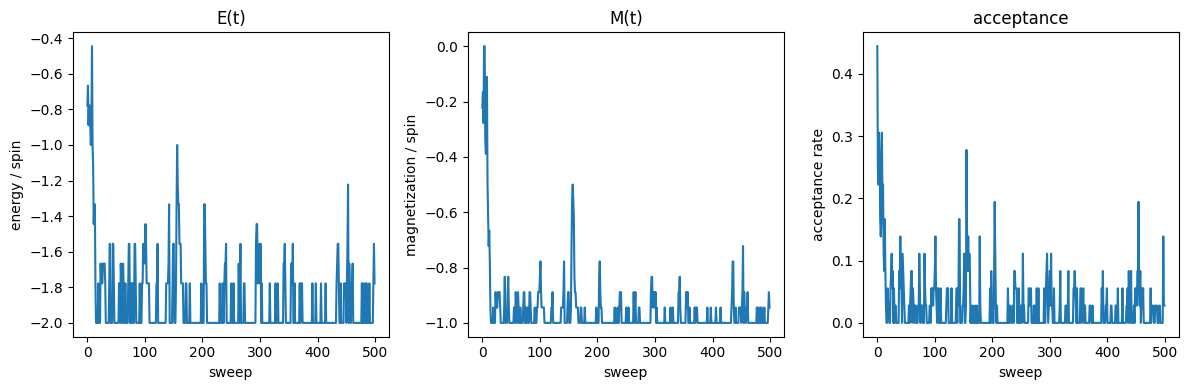

Building GIF (this may take a moment)...
Saved GIF to: glauber_evolution.gif


/var/folders/yd/rccc37dn22j6l0zn3lj5x7080000gn/T/ipykernel_57901/4078708840.py:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fname)


In [35]:
# ----------------- Run: equilibration (optional) + measurement -----------------
# (You can set n_eq_sweeps > 0 if you want to discard initial transients for equilibrium stats.)
print(f"Starting Glauber run: L={L}, T={T}, sweeps(eq={n_eq_sweeps},meas={n_meas_sweeps})")
# Optional: compute initial energy/magnetization
e0 = energy_per_spin(spins, J)
m0 = magnetization_per_spin(spins)
print(f"Initial e = {e0:.6f}, m = {m0:.6f}")

# Equilibration
for s in trange(n_eq_sweeps, desc="Equilibrating"):
    _ = glauber_sweep(spins, beta, J=J, rng=rng)

# Measurement arrays
energy_ts = []
mag_ts = []
accept_rates = []
snapshot_files = []

for sweep in trange(n_meas_sweeps, desc="Glauber sweeps"):
    accepts = glauber_sweep(spins, beta, J=J, rng=rng)
    # record observables once per sweep
    energy_ts.append(energy_per_spin(spins, J))
    mag_ts.append(magnetization_per_spin(spins))
    accept_rates.append(accepts / (L * L))
    # optionally save snapshot for visualization
    if sweep % sample_every == 0:
        fname = f"{snapshot_dir}/snapshot_{sweep:05d}.png"
        img = save_spin_snapshot(spins, outpath=fname, zoom=10)
        snapshot_files.append(fname)
    

# Convert to numpy arrays
energy_ts = np.array(energy_ts)
mag_ts = np.array(mag_ts)
accept_rates = np.array(accept_rates)

# ----------------- Quick summaries & plots -----------------
print(f"Mean energy per spin over measured sweeps: {energy_ts.mean():.6f}")
print(f"Mean magnetization per spin over measured sweeps: {mag_ts.mean():.6f}")
print(f"Mean acceptance rate: {accept_rates.mean():.3f}")

# Plot E(t), M(t), acceptance rate
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(energy_ts)
plt.xlabel("sweep"); plt.ylabel("energy / spin"); plt.title("E(t)")
plt.subplot(1,3,2)
plt.plot(mag_ts)
plt.xlabel("sweep"); plt.ylabel("magnetization / spin"); plt.title("M(t)")
plt.subplot(1,3,3)
plt.plot(accept_rates)
plt.xlabel("sweep"); plt.ylabel("acceptance rate"); plt.title("acceptance")
plt.tight_layout()
plt.show()

# Build GIF (optional; requires imageio)
if snapshot_files:
    print("Building GIF (this may take a moment)...")
    snapshot_files = sorted(snapshot_files)  # ensure correct order
    with imageio.get_writer(gif_out, mode='I', duration=0.12) as writer:
        for fname in snapshot_files:
            img = imageio.imread(fname)
            writer.append_data(img)
    print("Saved GIF to:", gif_out)